# Libraries

In [1]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import glob
import time

from IPython.display import clear_output
from transformers import AutoImageProcessor, TimesformerModel
from PIL import Image
from tqdm import tqdm
from matplotlib import pyplot as plt

# Video Information

In [2]:
video_location = "Arrest001_x264.mp4"
filename = video_location[:-4]

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
device

device(type='cuda')

# Extract Frame

In [5]:
save_location = filename
if not os.path.exists(save_location):
    os.mkdir(save_location)

In [6]:
save_name = os.path.join(save_location, '%05d.jpg')
!ffmpeg -i {video_location} -r 30 -q:v 2 -vf scale=320:240 {save_name}
clear_output()

In [7]:
print(f"Banyak frame pada video {filename} : {len(os.listdir(save_location))}")

Banyak frame pada video Arrest001_x264 : 2374


# Prepare Model

In [8]:
processor = AutoImageProcessor.from_pretrained("facebook/timesformer-base-finetuned-k400")
model_rgb = TimesformerModel.from_pretrained("facebook/timesformer-base-finetuned-k400")

preprocessor_config.json:   0%|          | 0.00/412 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/22.7k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/486M [00:00<?, ?B/s]

In [9]:
class RGBStreamModel(torch.nn.Module):
    def __init__(self, model_rgb, input_dim, num_classes):
        super(RGBStreamModel, self).__init__()
        self.model_rgb = model_rgb
        self.classifier = torch.nn.Linear(input_dim , num_classes)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x_rgb):
        out_rgb = self.model_rgb(pixel_values=x_rgb).last_hidden_state[:, 0]
        out = self.sigmoid(self.classifier(out_rgb))
        return out

In [10]:
input_dim = 768
num_classes = 1

model = RGBStreamModel(model_rgb,input_dim,num_classes)

In [11]:
weight_path = "best_model.pth"
if device == torch.device("cpu"):
  state_dict  = torch.load(weight_path,map_location=torch.device('cpu'))
else:
  state_dict = torch.load(weight_path)
model.load_state_dict(state_dict)
model.eval()

RGBStreamModel(
  (model_rgb): TimesformerModel(
    (embeddings): TimesformerEmbeddings(
      (patch_embeddings): TimesformerPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (time_drop): Dropout(p=0.0, inplace=False)
    )
    (encoder): TimesformerEncoder(
      (layer): ModuleList(
        (0-11): 12 x TimesformerLayer(
          (drop_path): Identity()
          (attention): TimeSformerAttention(
            (attention): TimesformerSelfAttention(
              (qkv): Linear(in_features=768, out_features=2304, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
            )
            (output): TimesformerSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): TimesformerIntermediate(
            (dense): Linear(in_features

In [12]:
model = model.to(device)

# Visualize Prediction

In [13]:
save_output_location = save_location + "_output"
if not os.path.exists(save_output_location):
    os.mkdir(save_output_location)

images = glob.glob(os.path.join(save_location, "*.jpg"))
images.sort()

In [14]:
num_frames = 8
segment = len(images) // num_frames

x_time = [jj for jj in range(len(images))]
y_pred = [0] * num_frames

In [15]:
start = 0
for i in tqdm(range(0,len(images))):
  if i < num_frames:
    cv_img = cv2.imread(images[i])
    h,w,_ = cv_img.shape
    cv_img = cv2.putText(cv_img, 'FPS : 0.0, Pred : 0.0', (5,15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,200,240), 2)
  else:
    clips = images[start:i]
    start_time = time.time()
    tokens = processor([Image.open(image) for image in clips], return_tensors='pt')
    pixel_values = tokens['pixel_values'].to(device)
    with torch.no_grad():
      outputs = model(pixel_values)
    end_time = time.time()
    FPS = 1/(end_time - start_time)
    FPS_formatted = "{:.5f}".format(FPS)
    anomaly_score = float(outputs.squeeze())
    anomaly_score_formatted = "{:.5f}".format(anomaly_score)
    y_pred.append(anomaly_score)

    cv_img = cv2.imread(images[i])
    cv_img = cv2.putText(cv_img, f"FPS : {FPS_formatted}, Pred : {anomaly_score_formatted}", (5,15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,200,240), 2)
    if anomaly_score > 0.5:
      cv_img = cv2.rectangle(cv_img, (0,0), (w,h), (0,0,255), 3)

    start += 1

  cv2.imwrite(os.path.join(save_output_location, os.path.basename(images[i])), cv_img)


  0%|          | 0/2374 [00:00<?, ?it/s]c:\Users\malif\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\feature_extraction_utils.py:149: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  return torch.tensor(value)
100%|██████████| 2374/2374 [14:58<00:00,  2.64it/s]


In [16]:
!ffmpeg -i {save_output_location}/%05d.jpg {save_output_location}.mp4
clear_output()

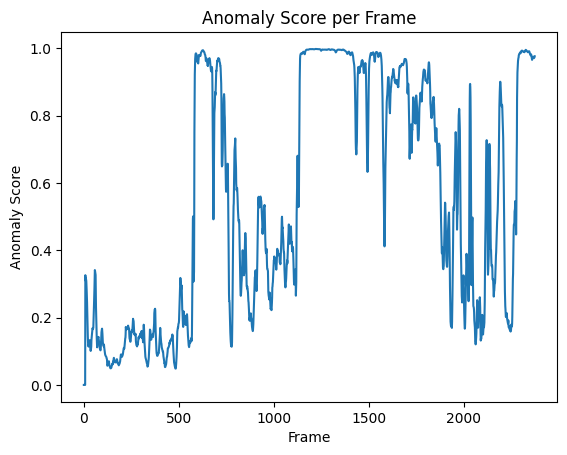

In [17]:
plt.plot(x_time, y_pred)
plt.xlabel("Frame")
plt.ylabel("Anomaly Score")
plt.title("Anomaly Score per Frame")
plt.savefig(save_output_location+".png", dpi=300)
plt.show()